In [1]:
import atlite
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import median

# 2021 ERA5 Cutout
For simplicity's sake, scaling the wind speeds will be done for just the year of 2021.

In [2]:
#Load in the cutout I made considering the BC wind turbine locations from generators.csv
#The cutout contains hourly data for the year of 2021
cutout = atlite.Cutout(path='BC_wind_turbines_2021.nc')
wind = cutout.data.wnd100m
wind

<xarray.DataArray 'wnd100m' (time: 8760, y: 27, x: 34)>
dask.array<open_dataset-72487a04f68aca2e422128a9101a6f4awnd100m, shape=(8760, 27, 34), dtype=float32, chunksize=(100, 27, 34), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -128.2 -128.0 -127.8 -127.5 ... -120.5 -120.2 -120.0
  * y        (y) float64 49.5 49.75 50.0 50.25 50.5 ... 55.25 55.5 55.75 56.0
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
    lon      (x) float64 dask.array<chunksize=(34,), meta=np.ndarray>
    lat      (y) float64 dask.array<chunksize=(27,), meta=np.ndarray>
Attributes:
    units:      m s**-1
    long_name:  100 metre wind speed
    module:     era5
    feature:    wind

In [3]:
#Coordinates for mean wind speed for the wind farms on Global Wind Atlas
windCoord = pd.read_csv('wind-coords.csv', index_col='index')
windCoord

,latitude,longitude,Wind Speed
index,,,
0,55.704126,-120.426360,7.879689
1,55.811775,-122.247353,7.968669
2,55.184599,-120.854677,7.170079
3,55.184599,-120.854677,7.170079
4,50.789021,-128.003295,7.500420
5,55.285560,-121.469056,8.364857
6,55.285560,-121.469056,8.364857
7,49.925611,-120.109281,8.218852
8,49.660175,-120.122212,8.329908


In [4]:
#Select the nearest squares on the ERA5 grid for each wind turbine farm
nearest = cutout.data.sel({'x': windCoord.longitude.values, 'y': windCoord.latitude.values}, 'nearest').coords
xNear = nearest.get('x').values
yNear = nearest.get('y').values

#Put these matched squares into the dataframe to line them up nice
windCoord['x'] = xNear
windCoord['y'] = yNear

#Create flags for the function later on that I will be applying on the dataframe. This is just to ignore the farms where one location has two turbine types
windCoord['Flag'] = [True, True, True, False, True, True, False, True, True, True]

#The dataframe to be used for scaling the wind speeds on the ERA5 data array
windCoord

,latitude,longitude,Wind Speed,x,y,Flag
index,,,,,,
0,55.704126,-120.426360,7.879689,-120.50,55.75,True
1,55.811775,-122.247353,7.968669,-122.25,55.75,True
2,55.184599,-120.854677,7.170079,-120.75,55.25,True
3,55.184599,-120.854677,7.170079,-120.75,55.25,False
4,50.789021,-128.003295,7.500420,-128.00,50.75,True
5,55.285560,-121.469056,8.364857,-121.50,55.25,True
6,55.285560,-121.469056,8.364857,-121.50,55.25,False
7,49.925611,-120.109281,8.218852,-120.00,50.00,True
8,49.660175,-120.122212,8.329908,-120.00,49.75,True


In [5]:
#Function to get INDEX values of the square in the ERA5 data array is
def getXY(row):
    x = 0
    y = 0
    for i in range(wind.x.size):
        if row['x'] == wind.x.values[i]:
            x = i
            break
    
    for j in range(wind.y.size):
        if row['y'] == wind.y.values[j]:
            y = j
            break

    return [x, y]

#Function to scale the wind speeds on the ERA5 data array
def scaleWind(row):
    if row['Flag']:
        #Scale the wind speeds at this location on the ERA5 data array
        windAtLocation = wind.sel(x=row['x'], y=row['y']).values
        scaled = windAtLocation * row['Wind Speed'] / np.mean(windAtLocation)
        #print(row['Wind Speed'] / np.mean(windAtLocation))
        return scaled
    else:
        #Do nothing
        return None

#Get scaled wind values and x-y coords
scaledWind = windCoord.apply(scaleWind, axis=1)
xy = windCoord.apply(getXY, axis=1)

#This will be used to hold the data array values to be assigned back to the cutout's dataset
toDataArray = wind

#Combine scaledWind and XY an reformat a bit
scaledWindXY = pd.DataFrame(data={'Wind': scaledWind, 'XY': xy}).dropna().reset_index().drop(columns='index')
scaledWindXY

,Wind,XY
0,"[8.764322, 10.719809, 12.105535, 12.2565975, 1...","[31, 25]"
1,"[11.432598, 11.569838, 11.1577835, 11.1405325,...","[24, 25]"
2,"[10.383702, 11.30935, 11.937386, 11.999865, 12...","[30, 23]"
3,"[10.015077, 11.305622, 11.928471, 12.807101, 1...","[1, 5]"
4,"[12.052588, 12.67303, 12.287453, 11.779226, 11...","[27, 23]"
5,"[5.5219574, 6.0848455, 6.377467, 6.9792128, 7....","[33, 2]"
6,"[5.979273, 6.816769, 7.163124, 7.260767, 7.251...","[33, 1]"
7,"[8.683911, 9.244623, 9.213175, 9.005119, 9.169...","[28, 23]"


In [6]:
#Writing the data in scaledWindXY into toDataArray
for i in range(scaledWindXY.index.size):
    #toDataArray[time, y, x], scaledWind.Wind contains the scaled hourly wind at location y, x
    toDataArray[:, scaledWindXY.loc[i].XY[1], scaledWindXY.loc[i].XY[0]] = scaledWindXY.loc[i].Wind

#Overwriting the wind data in the cutout with the scaled data
wind.data = toDataArray

# Creating Plots for Each Turbine and Its Respective Wind Distribution for 2021
Comparing scaled wind PDFs for the year of 2021 compared to the power generation curve for a turbine

In [7]:
#Read the Canadian wind turbine sheet
canadaTurbines = pd.read_excel('canada_turbines.xlsx')

#Filter down to just the turbines in BC
bcTurbines = canadaTurbines.loc[canadaTurbines['Province/Territory'] == 'British Columbia']

#Remove the Grouse Mountain turbine
bcTurbines = bcTurbines.drop(bcTurbines[bcTurbines['Project name'] == 'Grouse Mountain'].index)
bcTurbines

,OBJECTID,Province/Territory,Project name,Total project capacity (MW),Turbine identifier,Turbine number in project,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Manufacturer,Model,Commissioning date,Latitude,Longitude,Notes
900,901,British Columbia,Bear Mountain,102.0,BEA1,1/34,3000,82.0,78.0,Enercon,E-82/3000,2009,55.674403,-120.399656,NaN
901,902,British Columbia,Bear Mountain,102.0,BEA2,2/34,3000,82.0,78.0,Enercon,E-82/3000,2009,55.676152,-120.400476,NaN
902,903,British Columbia,Bear Mountain,102.0,BEA3,3/34,3000,82.0,78.0,Enercon,E-82/3000,2009,55.678465,-120.401640,NaN
903,904,British Columbia,Bear Mountain,102.0,BEA4,4/34,3000,82.0,78.0,Enercon,E-82/3000,2009,55.680526,-120.403098,NaN
904,905,British Columbia,Bear Mountain,102.0,BEA5,5/34,3000,82.0,78.0,Enercon,E-82/3000,2009,55.682379,-120.404906,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,1188,British Columbia,Shinish,15.0,SHS5,5/5,3000,114.0,100.0,Senvion,3.2 M114,2017,49.644184,-120.088395,Derated from 3200 kW
1188,1189,British Columbia,Moose Lake,15.0,MOL1,1/4,3750,141.0,99.0,Enercon,E-141/4200,2019,55.292758,-121.279058,Derated from 4200 kW
1189,1190,British Columbia,Moose Lake,15.0,MOL2,2/4,3750,141.0,99.0,Enercon,E-141/4200,2019,55.290407,-121.275710,Derated from 4200 kW
1190,1191,British Columbia,Moose Lake,15.0,MOL3,3/4,3750,141.0,99.0,Enercon,E-141/4200,2019,55.286023,-121.268157,Derated from 4200 kW


In [8]:
#Set up dataframe containing all the turbines to search for in the turbine database
importantCols = ['Project name', 'Model', 'Manufacturer', 'Turbine rated capacity (kW)', 'Rotor diameter (m)', 'Hub height (m)'] #Columns to use for search
modelNames = bcTurbines['Model'].unique() #Models of turbines (most important)

#Get the frame of turbines to search for
searchFrame = bcTurbines[importantCols].loc[bcTurbines['Model'].isin(modelNames)].copy().drop_duplicates()
searchFrame

,Project name,Model,Manufacturer,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m)
900,Bear Mountain,E-82/3000,Enercon,3000,82.0,78.0
935,Dokie Ridge Wind Farm,V90/3000,Vestas,3000,90.0,80.0
983,Quality Wind,V100,Vestas,1800,100.0,95.0
1027,Quality Wind,V90,Vestas,1800,90.0,95.0
1062,Cape Scott,V100,Vestas,1800,100.0,80.0
1117,Meikle,GE 2.75-120,GE,2750,120.0,110.0
1143,Meikle,GE 3.2-103,GE,3200,103.0,100.0
1178,Pennask,3.2 M114,Senvion,3000,114.0,100.0
1183,Shinish,3.2 M114,Senvion,3000,114.0,100.0
1188,Moose Lake,E-141/4200,Enercon,3750,141.0,99.0


In [9]:
def getConfig(model, h, id=-1):
    #ID used when there are multiple turbines with the same name, else just leave it blank
    if id >= 0:
        add = atlite.resource.get_oedb_windturbineconfig(model, id=id)
    else:
        add = atlite.resource.get_oedb_windturbineconfig(model)
    add['hub_height'] = h #This hub height affects generation when cutout.wind

    return add

con = []
#E-82/3000 - This one actually works great
con.append(getConfig('E-82/3000', 78.0))

#V90/3000 - Also works great
con.append(getConfig('V90/3000', 90.0))

#V100, 95.0m - Incorrectly labelled as just 'V100', it should've included the 1800. Also needs a specific ID that I had to manually look at due to having two V100/1800 turbines
con.append(getConfig('V100/1800', 95.0, 134))

#V90 - Literally doesn't exist in the wind turbine library, even as V90/1800. I took a guess and used the V90/2000 turbine. Also has an specific ID because of two turbines
con.append(getConfig('V90/2000', 95.0, 54))

#V100, 80.0m - Same as the one further up, just at 80.0m hub height instead of 95.0m
con.append(getConfig('V100/1800', 80.0, 134))

#GE 2.75-120 - Works great
con.append(getConfig('GE 2.75-120', 110.0))

#GE 3.2-103 - No clue, there's a GE 3.2-130 which has the correct power gen, but the rotor diameter is way off. Could it be a typo? 130 vs 103.
#There were no other clear options here, so I picked the GE 3.2-130
con.append(getConfig('GE 3.2-130', 100.0))

#3.2 M114 - There is not supposed to be a space between '3.2' and 'M114', the correct name is '3.2M114'
#Repeated as there are two locations that use these exact models
con.append(getConfig('3.2M114', 100.0))
con.append(getConfig('3.2M114', 100.0))

#E-141/4200 - Thank you Enercon for being the only turbines that are named consistently
con.append(getConfig('E-141/4200', 99.0))

searchFrame['Config'] = con
searchFrame

Multiple values for hub_height in dataset ([69.0, 78.0, 84.0]). Manual clean-up required. Using the averge 77m for now.
No hub_height defined in dataset. Manual clean-up required.Assuming a hub_height of 100m for now.
No hub_height defined in dataset. Manual clean-up required.Assuming a hub_height of 100m for now.
Multiple values for hub_height in dataset ([85.0, 98.3, 110.0, 139.0]). Manual clean-up required. Using the averge 108m for now.
Multiple values for hub_height in dataset ([85.0, 110.0, 134.0, 155.0]). Manual clean-up required. Using the averge 121m for now.
Multiple values for hub_height in dataset ([93.0, 119.0, 123.0, 143.0]). Manual clean-up required. Using the averge 119m for now.
Multiple values for hub_height in dataset ([93.0, 119.0, 123.0, 143.0]). Manual clean-up required. Using the averge 119m for now.
Multiple values for hub_height in dataset ([99.0, 129.0, 135.0, 159.0]). Manual clean-up required. Using the averge 130m for now.


,Project name,Model,Manufacturer,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Config
900,Bear Mountain,E-82/3000,Enercon,3000,82.0,78.0,"{'name': 'E-82/3000', 'manufacturer': 'Enercon..."
935,Dokie Ridge Wind Farm,V90/3000,Vestas,3000,90.0,80.0,"{'name': 'V90/3000', 'manufacturer': 'Vestas',..."
983,Quality Wind,V100,Vestas,1800,100.0,95.0,"{'name': 'V100/1800', 'manufacturer': 'Vestas'..."
1027,Quality Wind,V90,Vestas,1800,90.0,95.0,"{'name': 'V90/2000', 'manufacturer': 'Vestas',..."
1062,Cape Scott,V100,Vestas,1800,100.0,80.0,"{'name': 'V100/1800', 'manufacturer': 'Vestas'..."
1117,Meikle,GE 2.75-120,GE,2750,120.0,110.0,"{'name': 'GE120/2750', 'manufacturer': 'GE Win..."
1143,Meikle,GE 3.2-103,GE,3200,103.0,100.0,"{'name': 'GE130/3200', 'manufacturer': 'GE Win..."
1178,Pennask,3.2 M114,Senvion,3000,114.0,100.0,"{'name': 'S114/3200', 'manufacturer': 'Senvion..."
1183,Shinish,3.2 M114,Senvion,3000,114.0,100.0,"{'name': 'S114/3200', 'manufacturer': 'Senvion..."
1188,Moose Lake,E-141/4200,Enercon,3750,141.0,99.0,"{'name': 'E-141/4200', 'manufacturer': 'Enerco..."


In [10]:
#Read in generators.csv
generatorPath = './data-pull/supply/generators.csv'
generators = pd.read_csv(generatorPath)

#Filter to wind generators in BC for now
windBC = generators.loc[generators.province.eq('BC') & generators.gen_type_copper.eq('wind')][['project_name', 'location', 'latitude', 'longitude']]

#Rename some projects for the merge later below
windBC.at[303, 'project_name'] = 'Dokie Ridge Wind Farm'
windBC.at[427, 'project_name'] = 'Quality Wind'
windBC.at[455, 'project_name'] = 'Shinish'

#Get the final dataframe containing the wind turbine clusters to produce wind generation values from
finalFrame = searchFrame.merge(windBC.rename(columns={'project_name': 'Project name'}))
finalFrame

,Project name,Model,Manufacturer,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Config,location,latitude,longitude
0,Bear Mountain,E-82/3000,Enercon,3000,82.0,78.0,"{'name': 'E-82/3000', 'manufacturer': 'Enercon...",Dawson Creek,55.704126,-120.426360
1,Dokie Ridge Wind Farm,V90/3000,Vestas,3000,90.0,80.0,"{'name': 'V90/3000', 'manufacturer': 'Vestas',...",Chetwynd,55.811775,-122.247353
2,Quality Wind,V100,Vestas,1800,100.0,95.0,"{'name': 'V100/1800', 'manufacturer': 'Vestas'...",Tumbler Ridge,55.184599,-120.854677
3,Quality Wind,V90,Vestas,1800,90.0,95.0,"{'name': 'V90/2000', 'manufacturer': 'Vestas',...",Tumbler Ridge,55.184599,-120.854677
4,Cape Scott,V100,Vestas,1800,100.0,80.0,"{'name': 'V100/1800', 'manufacturer': 'Vestas'...",Port Hardy,50.789021,-128.003295
5,Meikle,GE 2.75-120,GE,2750,120.0,110.0,"{'name': 'GE120/2750', 'manufacturer': 'GE Win...",Tumbler Ridge,55.285560,-121.469056
6,Meikle,GE 3.2-103,GE,3200,103.0,100.0,"{'name': 'GE130/3200', 'manufacturer': 'GE Win...",Tumbler Ridge,55.285560,-121.469056
7,Pennask,3.2 M114,Senvion,3000,114.0,100.0,"{'name': 'S114/3200', 'manufacturer': 'Senvion...",Westbank,49.925611,-120.109281
8,Shinish,3.2 M114,Senvion,3000,114.0,100.0,"{'name': 'S114/3200', 'manufacturer': 'Senvion...",Summerland,49.660175,-120.122212
9,Moose Lake,E-141/4200,Enercon,3750,141.0,99.0,"{'name': 'E-141/4200', 'manufacturer': 'Enerco...",Tumbler Ridge,55.285633,-121.298571


# The Plots Begin
Everything below here are the plots of the turbine power generation curves vs. their locations' wind probability density

In [11]:
#Need this in order to calculate a value on the power generation curve at, say 7.27. This falls between 7.0 and 7.5 (or 8.0 on some turbines)
def linearApprox(v, p, val):
    #v = Velocities
    #p = Power generations
    #val = Value to approximate on the power generation curve
    dex = np.searchsorted(v, val)

    #Get slope between two points, rise over run
    slope = (p[dex+1]-p[dex]) / (v[dex+1] - v[dex])

    #Perform linear approximation to estimate where val would be on the power generation curve
    return p[dex] + slope * (val - v[dex])

#This handles all of the plots and their formatting
def turbineVSpdf(turbine, wind, meanY, medY, title):
    #turbine = index from finalFrame
    #wind = index from scaledWindXY
    #meanY = Trial and error thing for getting the vertical lines to stop at the intersection for the mean
    #medY = Same as meanY, but for the median
    #title = Title for the plots

    #Some turbines don't start at [0, 0], this concatenation guarantees a [0, 0] point for better looking curves
    velocity = np.concatenate((np.array([0]), finalFrame.loc[turbine]['Config']['V']))
    power = np.concatenate((np.array([0]), finalFrame.loc[turbine]['Config']['POW']))

    #Mean and median of the pdf
    pdfMean = np.mean(scaledWindXY.loc[wind]['Wind'])
    pdfMed = median(scaledWindXY.loc[wind]['Wind'])

    pwrMean = linearApprox(velocity, power, pdfMean)
    pwrMed = linearApprox(velocity, power, pdfMed)

    fig, (pwr, pdf) = plt.subplots(ncols=1, nrows=2, sharex=True)

    fig.set_figheight(8)
    fig.set_figwidth(12)
    fig.set_tight_layout('pad')
    fig.suptitle(title)

    #The main power curve
    pwr.plot(velocity, power, linewidth=3)

    #Lines for mean and median of the pdf curve
    pwr.hlines(y=pwrMean, xmin=0, xmax=pdfMean, linestyles='dashed', colors='red', alpha=0.25)
    pwr.hlines(y=pwrMed, xmin=0, xmax=pdfMed, linestyles='dashed', colors='green', alpha=0.25)

    #Plot intersections
    pwr.plot(pdfMean, pwrMean, marker='o', markersize=5, color='red')
    pwr.plot(pdfMed, pwrMed, marker='o', markersize=5, color='green')

    pwr.set_xlim([0, np.max(velocity)])
    pwr.set_ylabel('Power generation (MW)', fontsize=14)

    pwr.legend(['Power generation curve', 'PDF mean intersection', 'PDF median intersection'], bbox_to_anchor=(1, 1))

    #The main pdf curve
    sns.kdeplot(data=scaledWindXY.loc[wind], x='Wind', color='black', linewidth=3)

    #Lines for mean and median of the pdf curve
    pdf.vlines(x=pdfMean, ymin=0, ymax=meanY, linestyles='dashed', colors='red', clip_on=False, alpha=0.25)
    pdf.vlines(x=pdfMed, ymin=0, ymax=medY, linestyles='dashed', colors='green', clip_on=False, alpha=0.25)

    data = pdf.lines[0].get_xydata()

    pdf.set_ylim([0, np.max(data[:, 1]) + 0.005])
    pdf.set_xlabel('Wind speed (m/s)', fontsize=14)
    pdf.set_ylabel('Probability density', fontsize=14)

    pdf.legend(['Probability distribution function', 'PDF mean', 'PDF median'], bbox_to_anchor=(1.355, 1))

    plt.show()

#Seaborn theme
sns.set_theme()

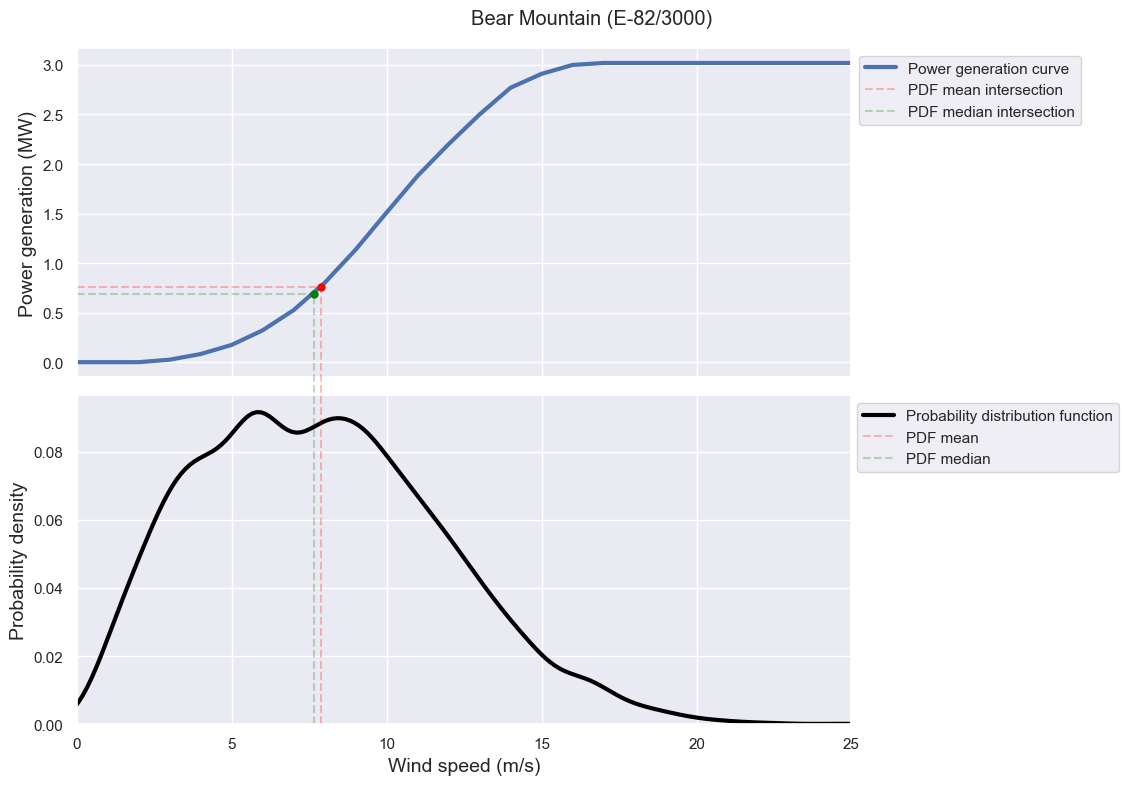

In [12]:
#Bear Mountain
turbineVSpdf(0, 0, 0.129, 0.125, 'Bear Mountain (E-82/3000)')

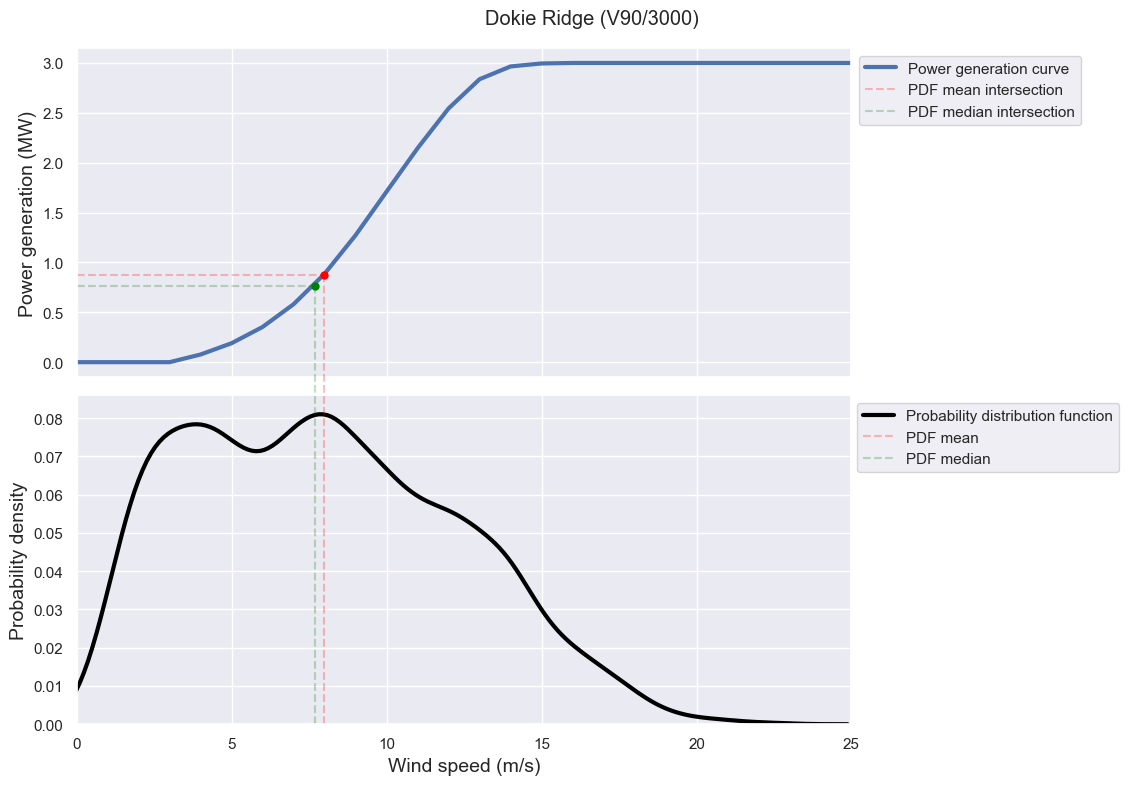

In [13]:
#Dokie Ridge
turbineVSpdf(1, 1, 0.118, 0.114, 'Dokie Ridge (V90/3000)')

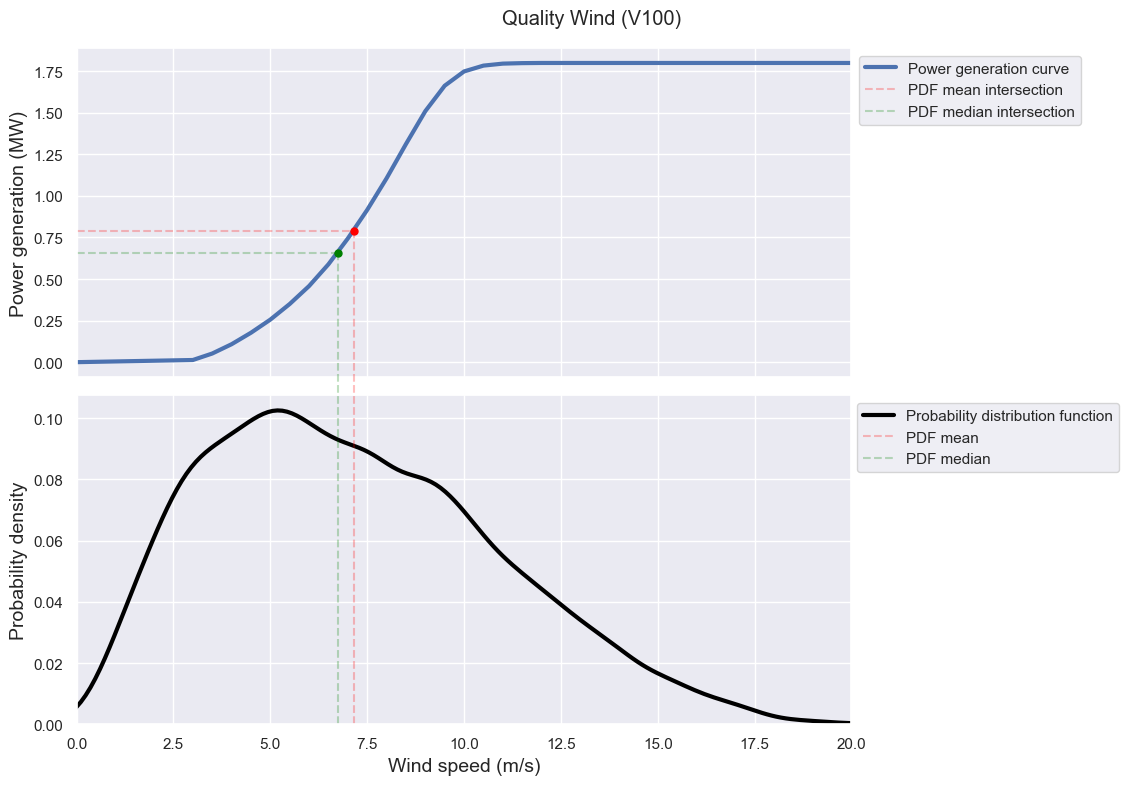

In [14]:
#Quality Wind 1
turbineVSpdf(2, 2, 0.162, 0.155, 'Quality Wind (V100)')

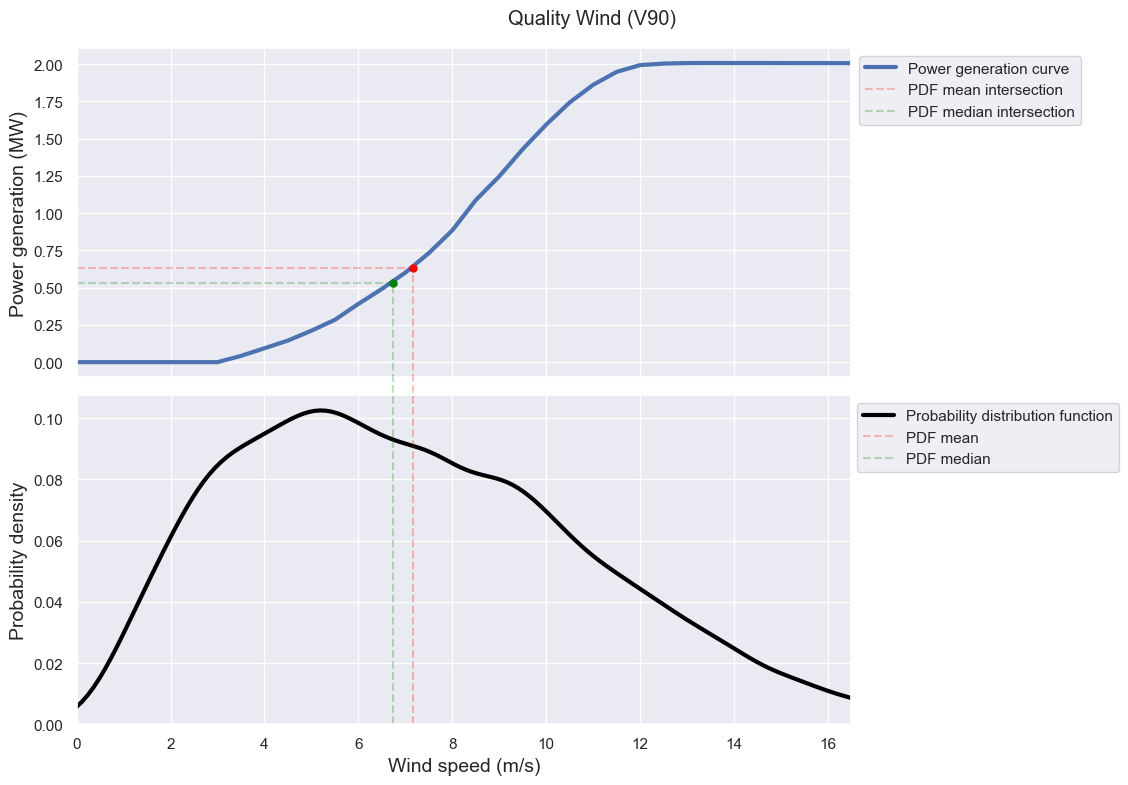

In [15]:
#Quality Wind 2
turbineVSpdf(3, 2, 0.15, 0.145, 'Quality Wind (V90)')

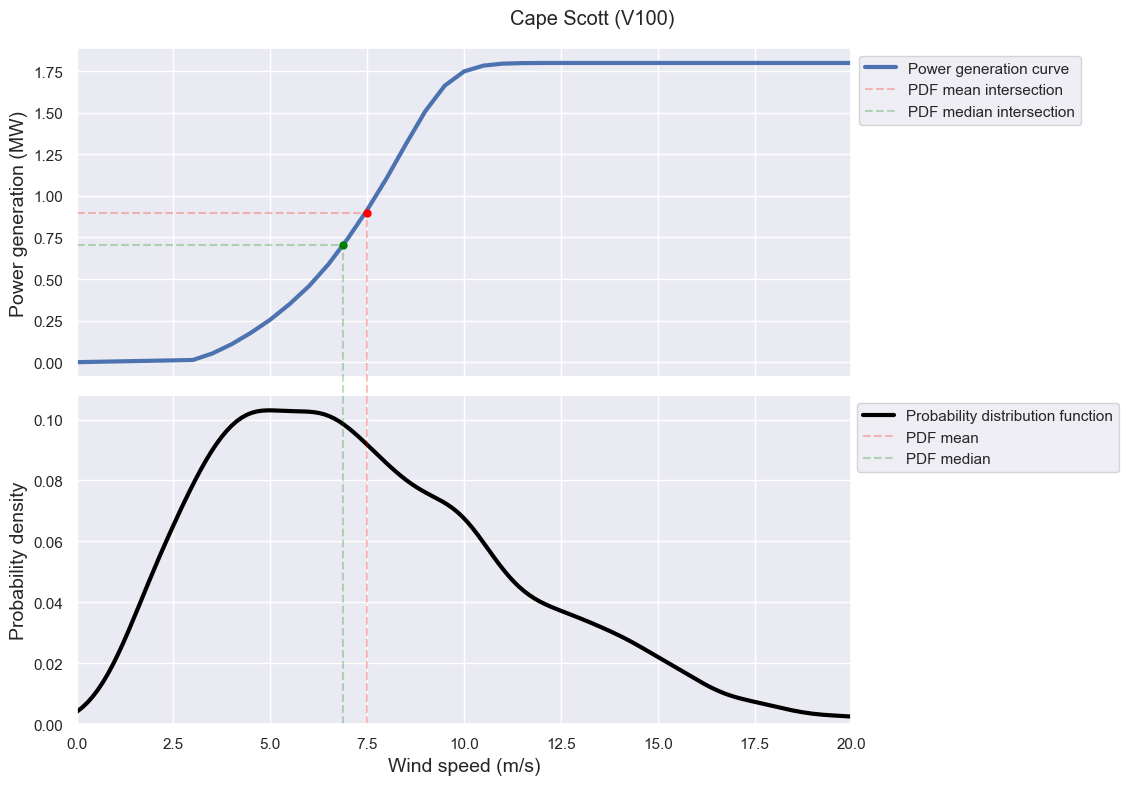

In [16]:
#Cape Scott
turbineVSpdf(4, 3, 0.17, 0.155, 'Cape Scott (V100)')

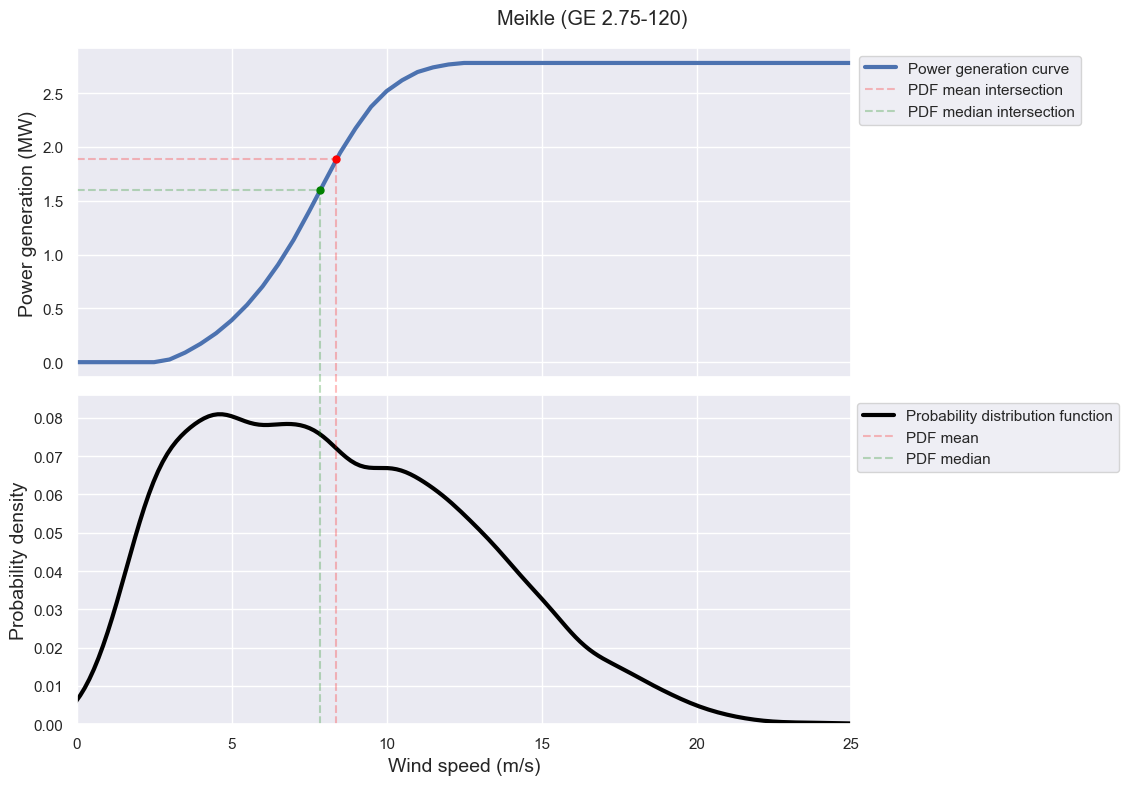

In [17]:
#Meikle 1
turbineVSpdf(5, 4, 0.148, 0.14, 'Meikle (GE 2.75-120)')

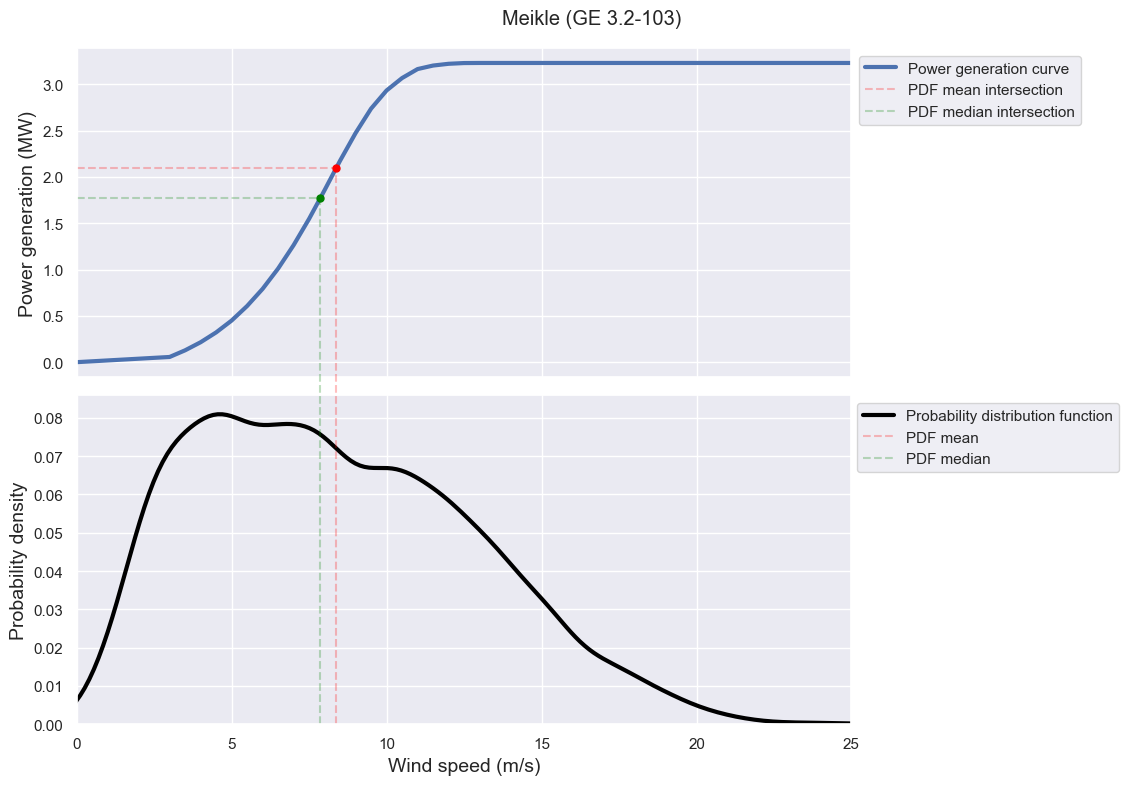

In [18]:
#Meikle 2
turbineVSpdf(6, 4, 0.145, 0.138, 'Meikle (GE 3.2-103)')

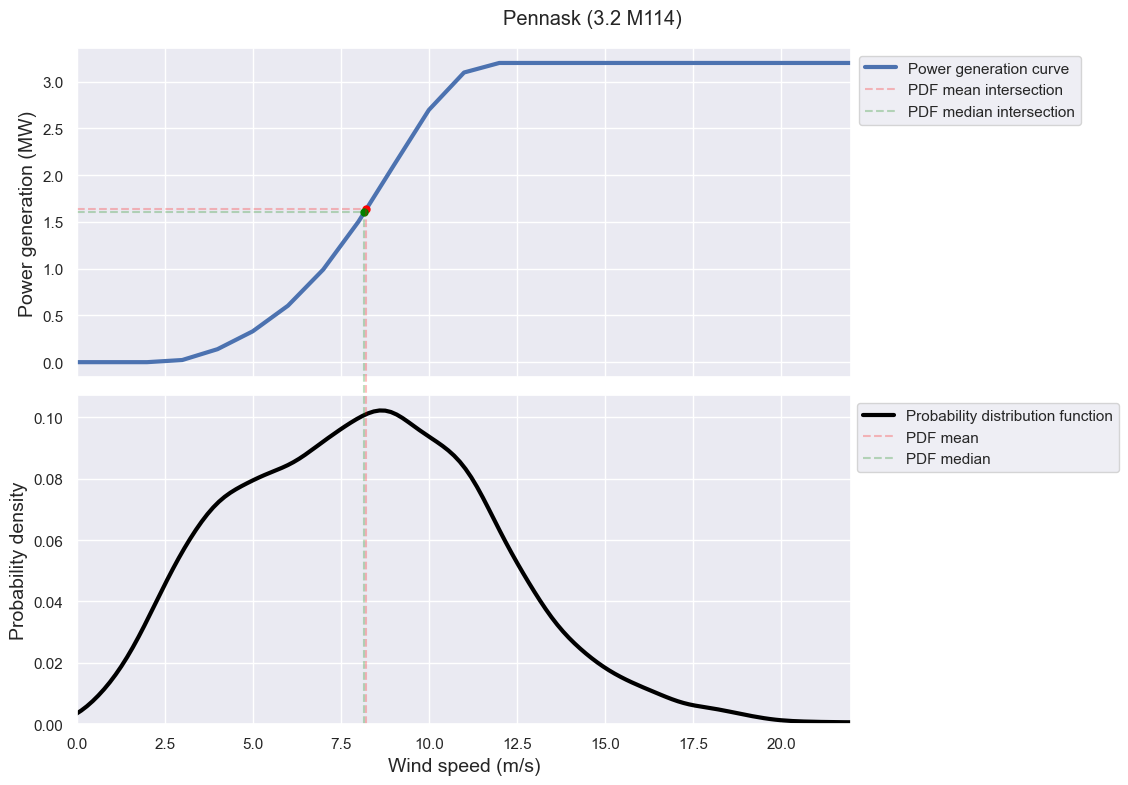

In [19]:
#Pennask
turbineVSpdf(7, 5, 0.168, 0.168, 'Pennask (3.2 M114)')

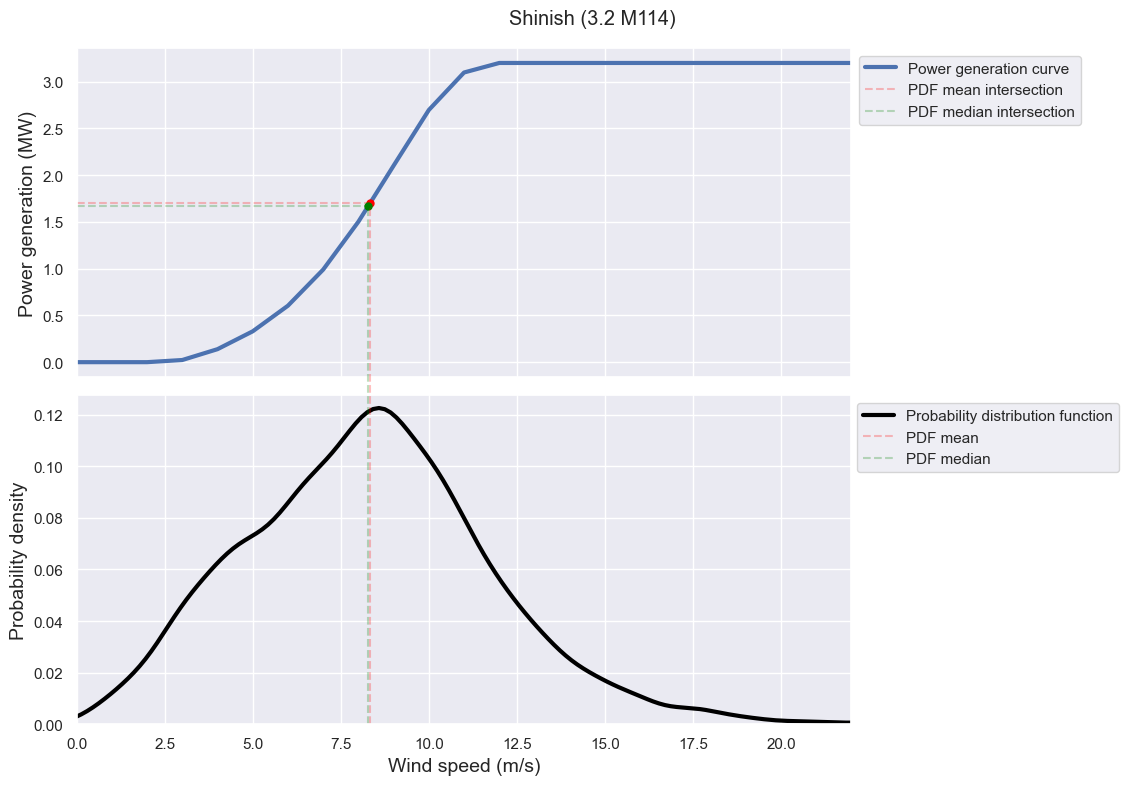

In [20]:
#Shinish
turbineVSpdf(8, 6, 0.2, 0.2, 'Shinish (3.2 M114)')

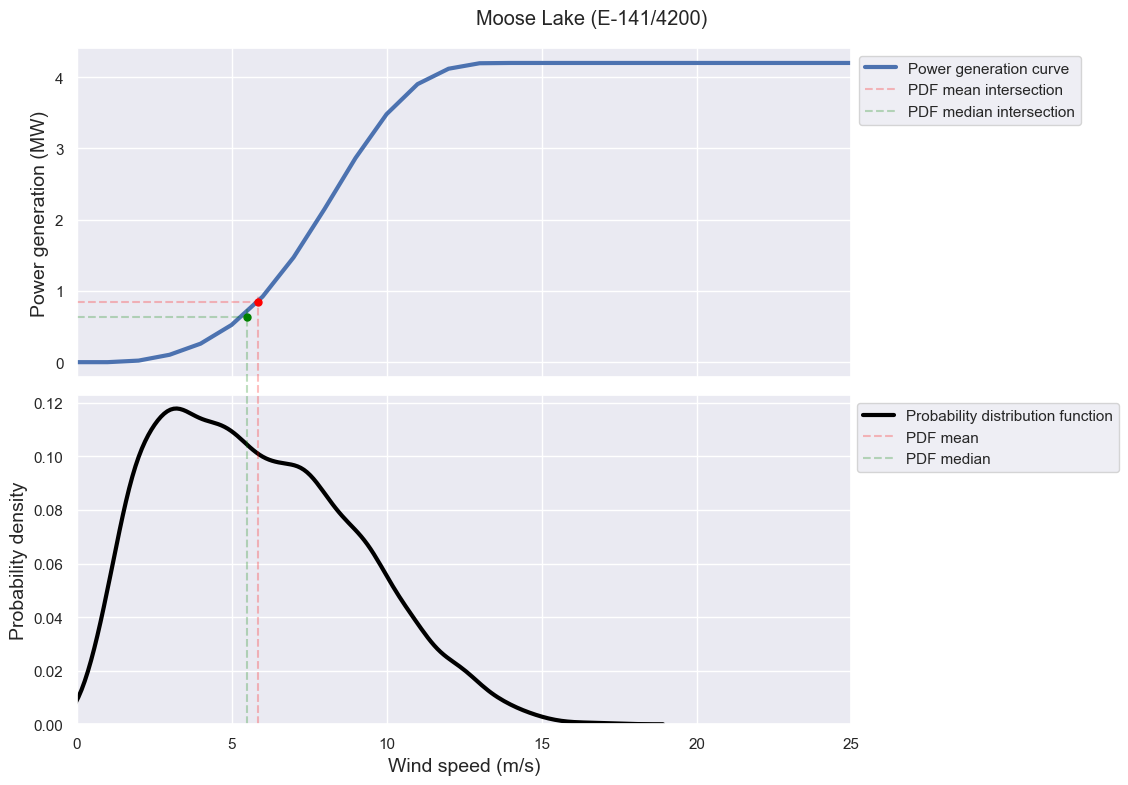

In [21]:
#Moose Lake
turbineVSpdf(9, 7, 0.16, 0.155, 'Moose Lake (E-141/4200)')